# Exploratory Data Analysis of WeightDataset

This notebook analyzes the structure and characteristics of the WeightDataset used in the autoencoder training. The dataset contains neural network weights that are used to train an autoencoder model.

In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from omegaconf import OmegaConf

import hydra
from omegaconf import OmegaConf
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from dataset import WeightDataset

c:\Users\matze\anaconda3\envs\hyper-diffusion\lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")
c:\Users\matze\anaconda3\envs\hyper-diffusion\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## 1. Load Configuration and Dataset

Load the configuration and initialize the dataset with the same parameters used in training.

In [2]:
cfg = OmegaConf.load('configs/default.yaml')

# Initialize dataset
dataset = WeightDataset(
    mlps_folder="../mlp_weights/3d_128_plane_multires_4_manifoldplus_slower_no_clipgrad",
    wandb_logger=None,
    model_dims=cfg.dataset.model_dims,
    mlp_kwargs=cfg.dataset.mlp_kwargs,
    cfg=cfg.dataset
)

print(f"Dataset size: {len(dataset)}")

Dataset size: 4045


## 2. Analyze Sample Structure

In [3]:
# Get a few samples
samples = [dataset[i] for i in range(3)]

for i, (weights, weights_prev, _) in enumerate(samples):
    print(f"\nSample {i+1}:")
    print(f"Weights shape: {weights.shape}")
    print(f"Weights statistics:")
    print(f"  Mean: {weights.mean():.4f}")
    print(f"  Std: {weights.std():.4f}")
    print(f"  Min: {weights.min():.4f}")
    print(f"  Max: {weights.max():.4f}")


Sample 1:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1628
  Std: 0.9083
  Min: -18.7730
  Max: 10.6990

Sample 2:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1253
  Std: 0.7616
  Min: -12.4229
  Max: 7.2907

Sample 3:
Weights shape: torch.Size([36737])
Weights statistics:
  Mean: -0.1241
  Std: 0.8126
  Min: -15.2188
  Max: 7.0414


c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


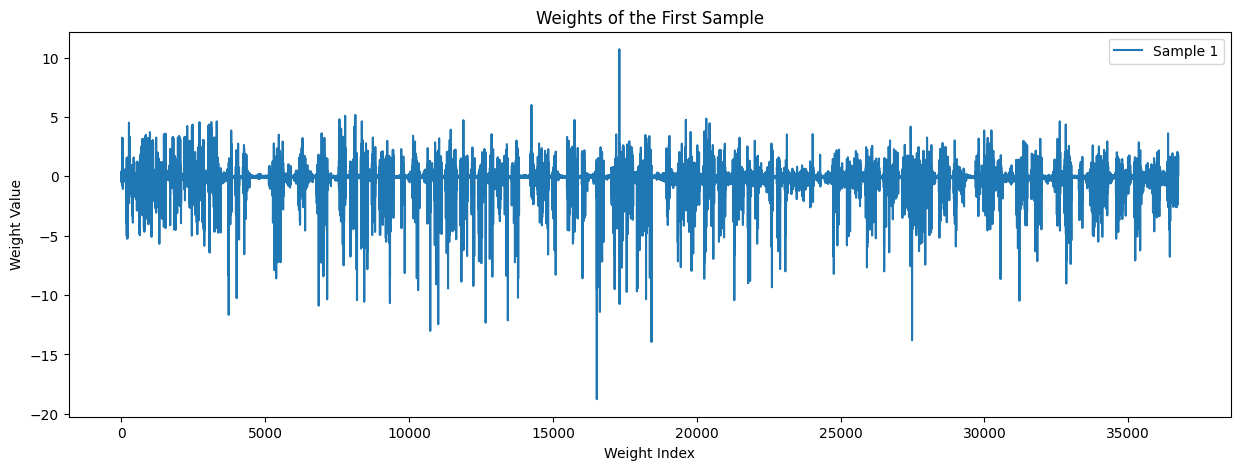

In [4]:
plt.figure(figsize=(15, 5))
for idx, (weights, _, _) in enumerate(samples[:1]):
    plt.plot(weights.numpy(), label=f'Sample {idx+1}')
plt.title('Weights of the First Sample')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

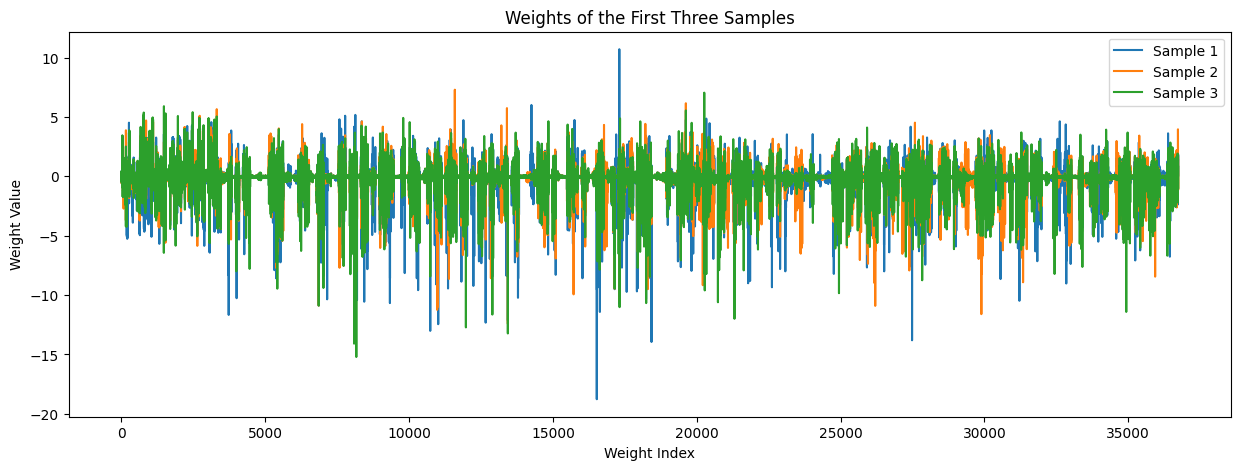

In [5]:
plt.figure(figsize=(15, 5))
for idx, (weights, _, _) in enumerate(samples):
    plt.plot(weights.numpy(), label=f'Sample {idx+1}')
plt.title('Weights of the First Three Samples')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')
plt.legend()
plt.show()

## 3. Distribution Analysis

Let's analyze the distribution of weights across multiple samples to understand their statistical properties.

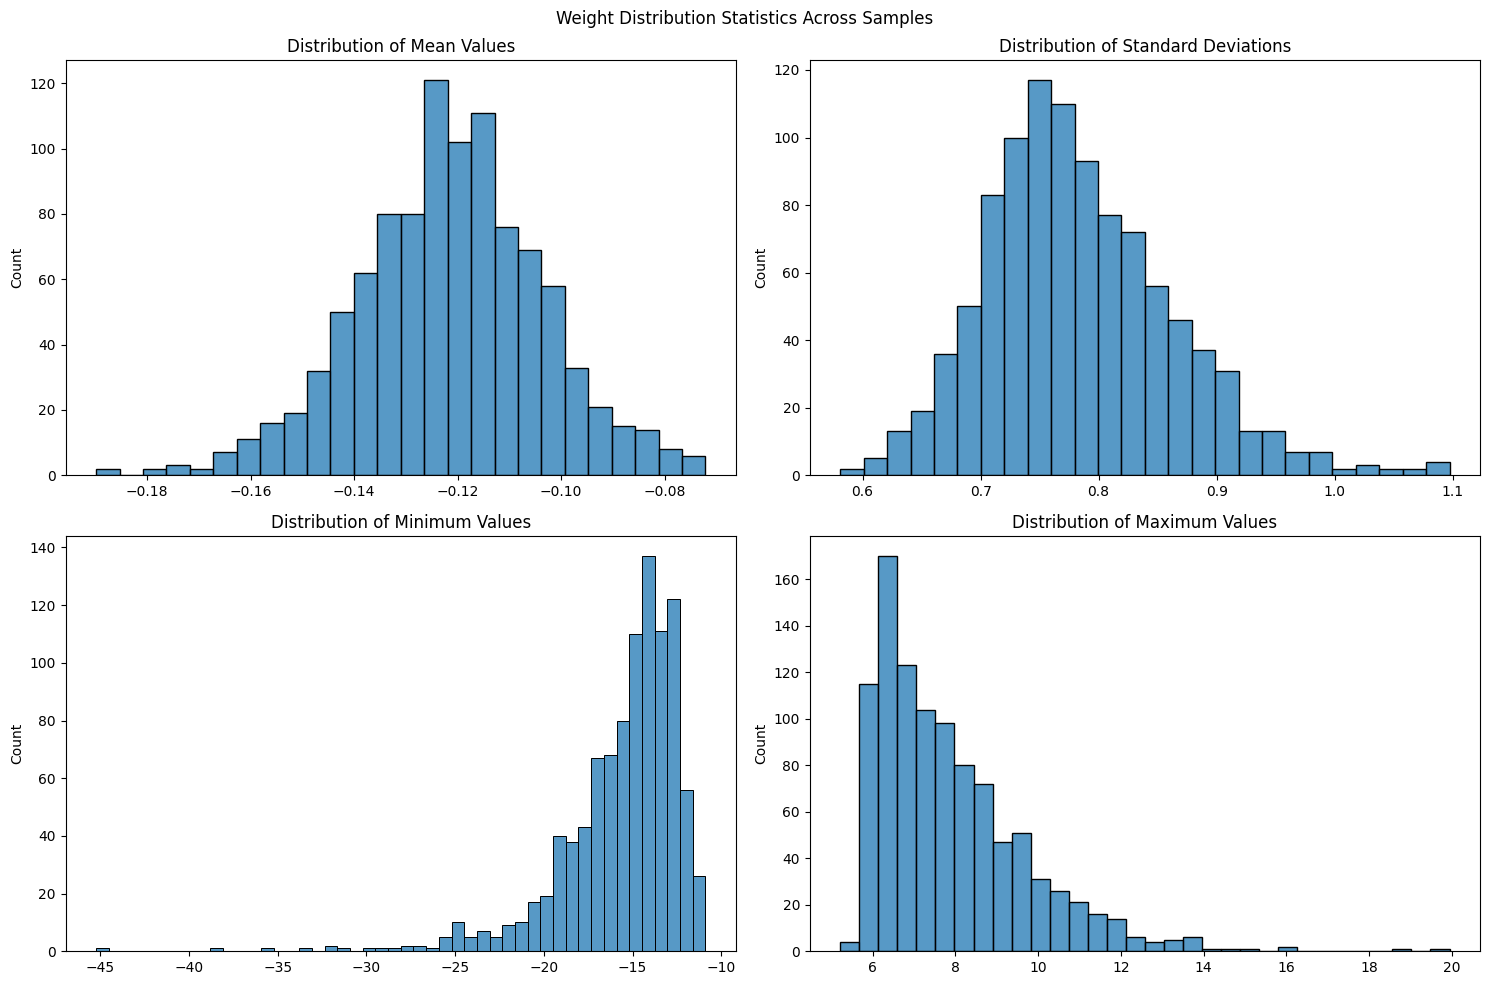

In [6]:
def analyze_weight_distribution(dataset, n_samples=1000):
    # Collect statistics from multiple samples
    means = []
    stds = []
    mins = []
    maxs = []
    
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        means.append(weights.mean().item())
        stds.append(weights.std().item())
        mins.append(weights.min().item())
        maxs.append(weights.max().item())
    
    return means, stds, mins, maxs

means, stds, mins, maxs = analyze_weight_distribution(dataset)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Weight Distribution Statistics Across Samples')

sns.histplot(means, ax=axes[0,0])
axes[0,0].set_title('Distribution of Mean Values')

sns.histplot(stds, ax=axes[0,1])
axes[0,1].set_title('Distribution of Standard Deviations')

sns.histplot(mins, ax=axes[1,0])
axes[1,0].set_title('Distribution of Minimum Values')

sns.histplot(maxs, ax=axes[1,1])
axes[1,1].set_title('Distribution of Maximum Values')

plt.tight_layout()
plt.show()

## 4.0 MLP Architecture

In [ ]:
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from mlp_models import MLP3D

#Current parameters used for the MLP
out_size = 1
hidden_neurons = [128, 128, 128]
multires = 4
use_leaky_relu = False

model = MLP3D(
    out_size=out_size,
    hidden_neurons=hidden_neurons,
    use_leaky_relu=use_leaky_relu,
    multires=multires,
    output_type="occ"
)

print("MLP Architecture:")
print("-----------------")
print(f"Model type: MLP3D")
print(f"Output size: {out_size}")
print(f"Hidden layers: {hidden_neurons}")
print(f"Positional encoding (multires): {multires}")
print(f"Use Leaky ReLU: {use_leaky_relu}")
print(f"Output type: occ")
print("\nLayer details:")
print("-------------")

# Count total parameters
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape} - {param.numel()} parameters")
        total_params += param.numel()

print(f"\nTotal trainable parameters: {total_params:,}")

# Print model summary
print("\nModel Summary:")
print("-------------")
print(model)


MLP Architecture:
-----------------
Model type: MLP3D
Output size: 1
Hidden layers: [128, 128, 128]
Positional encoding (multires): 4
Use Leaky ReLU: False
Output type: occ

Layer details:
-------------
layers.0.weight: torch.Size([128, 27]) - 3456 parameters
layers.0.bias: torch.Size([128]) - 128 parameters
layers.1.weight: torch.Size([128, 128]) - 16384 parameters
layers.1.bias: torch.Size([128]) - 128 parameters
layers.2.weight: torch.Size([128, 128]) - 16384 parameters
layers.2.bias: torch.Size([128]) - 128 parameters
layers.3.weight: torch.Size([1, 128]) - 128 parameters
layers.3.bias: torch.Size([1]) - 1 parameters

Total trainable parameters: 36,737

Model Summary:
-------------
MLP3D(
  (layers): ModuleList(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [8]:
index_map = []
start_idx = 0

print("\nParameter Index Mapping:")
print("------------------------")

for name, param in model.named_parameters():
    if param.requires_grad:
        n_param = param.numel()
        end_idx = start_idx + n_param
        index_map.append((start_idx, end_idx, name, param.shape))
        print(f"{name:<30} | Indices: [{start_idx:>4}, {end_idx-1:>4}] | Shape: {param.shape}")
        start_idx = end_idx



Parameter Index Mapping:
------------------------
layers.0.weight                | Indices: [   0, 3455] | Shape: torch.Size([128, 27])
layers.0.bias                  | Indices: [3456, 3583] | Shape: torch.Size([128])
layers.1.weight                | Indices: [3584, 19967] | Shape: torch.Size([128, 128])
layers.1.bias                  | Indices: [19968, 20095] | Shape: torch.Size([128])
layers.2.weight                | Indices: [20096, 36479] | Shape: torch.Size([128, 128])
layers.2.bias                  | Indices: [36480, 36607] | Shape: torch.Size([128])
layers.3.weight                | Indices: [36608, 36735] | Shape: torch.Size([1, 128])
layers.3.bias                  | Indices: [36736, 36736] | Shape: torch.Size([1])


In [9]:
def format_param_ranges(param_tensor, start_idx, name):
    shape = param_tensor.shape
    if len(shape) == 2:  # weight matrix
        lines = [f"{name} ({shape[0]} × {shape[1]})"]
        for i in range(shape[0]):
            idx_start = start_idx + i * shape[1]
            idx_end = idx_start + shape[1] - 1
            lines.append(f"  → Neuron {i:>3}: [{idx_start:>5}, {idx_end:>5}]")
        return lines, start_idx + shape[0] * shape[1]
    elif len(shape) == 1:  # bias
        idx_end = start_idx + shape[0] - 1
        return [f"{name} ({shape[0]},)", f"  → Neurons 0–{shape[0]-1}: [{start_idx}, {idx_end}]"], idx_end + 1
    elif len(shape) == 0:  # scalar
        return [f"{name} (scalar): [{start_idx}]"], start_idx + 1
    else:
        raise ValueError(f"Unexpected parameter shape: {shape}")

start = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        lines, start = format_param_ranges(param, start, name)
        for l in lines:
            print(l)
        print()


layers.0.weight (128 × 27)
  → Neuron   0: [    0,    26]
  → Neuron   1: [   27,    53]
  → Neuron   2: [   54,    80]
  → Neuron   3: [   81,   107]
  → Neuron   4: [  108,   134]
  → Neuron   5: [  135,   161]
  → Neuron   6: [  162,   188]
  → Neuron   7: [  189,   215]
  → Neuron   8: [  216,   242]
  → Neuron   9: [  243,   269]
  → Neuron  10: [  270,   296]
  → Neuron  11: [  297,   323]
  → Neuron  12: [  324,   350]
  → Neuron  13: [  351,   377]
  → Neuron  14: [  378,   404]
  → Neuron  15: [  405,   431]
  → Neuron  16: [  432,   458]
  → Neuron  17: [  459,   485]
  → Neuron  18: [  486,   512]
  → Neuron  19: [  513,   539]
  → Neuron  20: [  540,   566]
  → Neuron  21: [  567,   593]
  → Neuron  22: [  594,   620]
  → Neuron  23: [  621,   647]
  → Neuron  24: [  648,   674]
  → Neuron  25: [  675,   701]
  → Neuron  26: [  702,   728]
  → Neuron  27: [  729,   755]
  → Neuron  28: [  756,   782]
  → Neuron  29: [  783,   809]
  → Neuron  30: [  810,   836]
  → Neuron  

## 4. Correlation Analysis

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


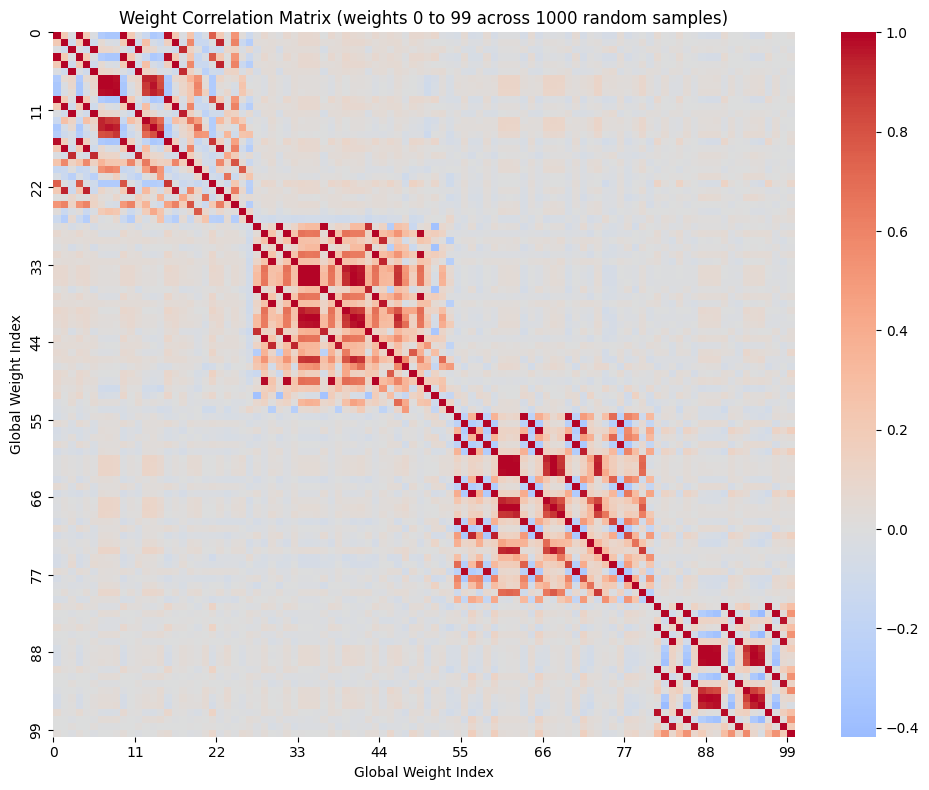

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_weight_correlations(dataset, n_samples=5, seed=42, start_index=0, end_index=None):
    if end_index is None:
        raise ValueError("You must specify end_index when n_weights is not provided.")

    rng = np.random.default_rng(seed)
    indices = rng.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)

    weight_list = []
    for i in indices:
        weights, _, _ = dataset[i]
        weight_list.append(weights.numpy()[start_index:end_index])

    weights_2d = np.stack(weight_list)
    corr_matrix = np.corrcoef(weights_2d, rowvar=False)

    # Global tick labels
    tick_labels = list(range(start_index, end_index))
    n_weights = end_index - start_index

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

    # Set global tick labels
    ax.set_xticks(np.linspace(0, n_weights - 1, 10).astype(int))
    ax.set_yticks(np.linspace(0, n_weights - 1, 10).astype(int))
    ax.set_xticklabels([tick_labels[i] for i in np.linspace(0, n_weights - 1, 10).astype(int)])
    ax.set_yticklabels([tick_labels[i] for i in np.linspace(0, n_weights - 1, 10).astype(int)])

    plt.title(f'Weight Correlation Matrix (weights {start_index} to {end_index - 1} across {n_samples} random samples)')
    plt.xlabel('Global Weight Index')
    plt.ylabel('Global Weight Index')
    plt.tight_layout()
    plt.show()


analyze_weight_correlations(dataset, n_samples=1000, start_index=0, end_index=100)


c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")
c:\U

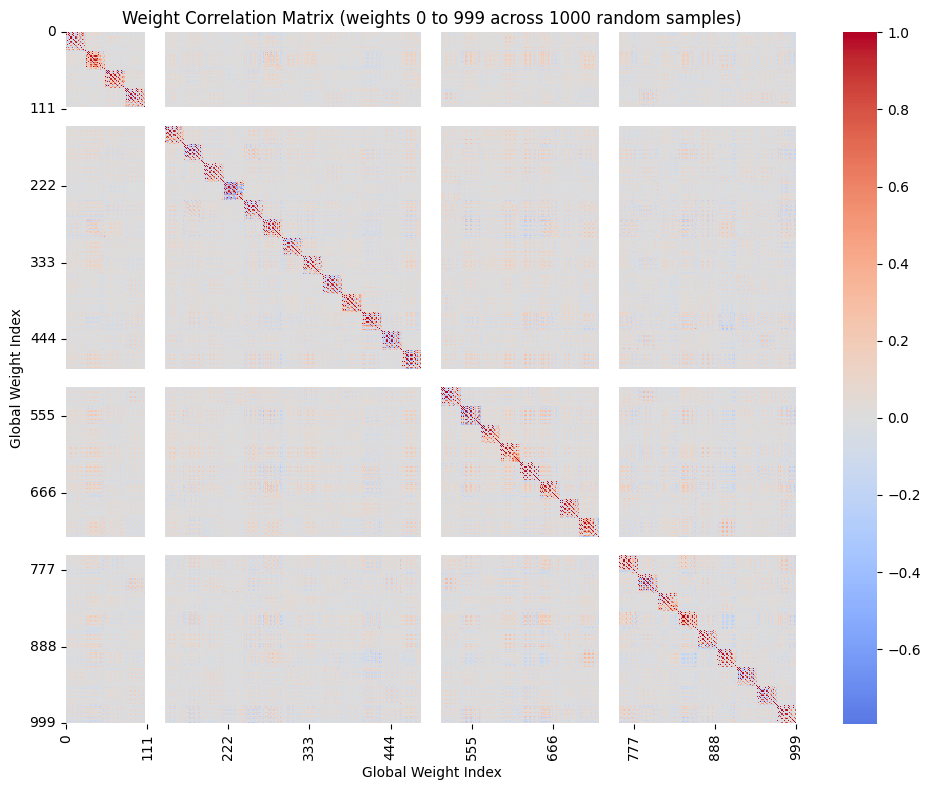

In [11]:
analyze_weight_correlations(dataset, n_samples=1000, start_index=0, end_index=1000)

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")
c:\U

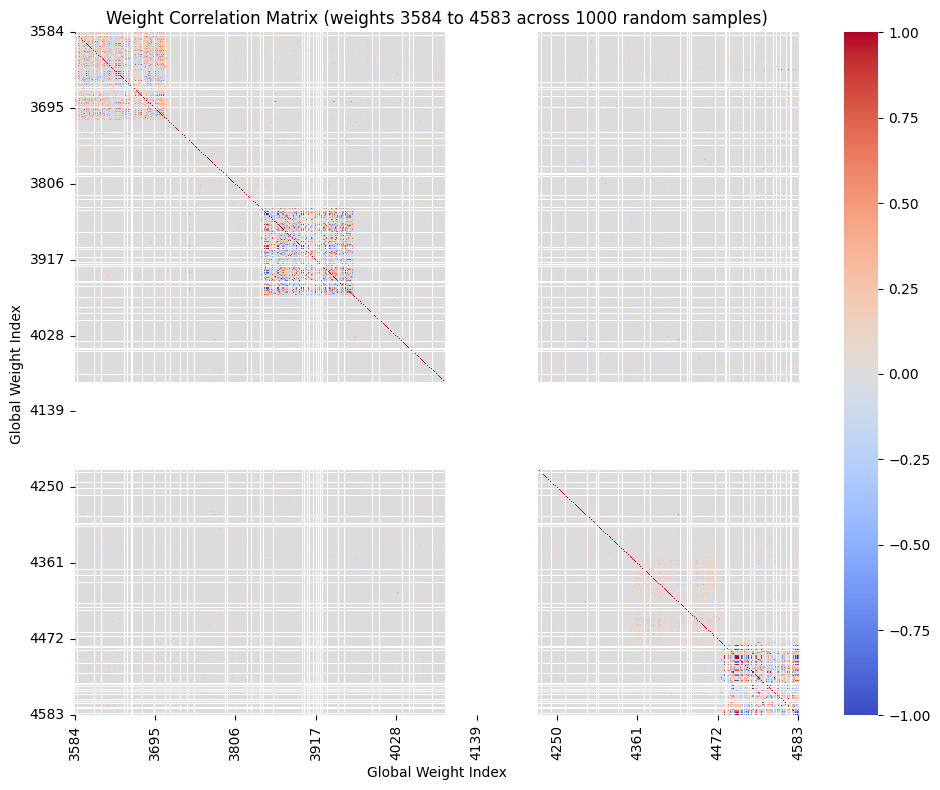

In [12]:
analyze_weight_correlations(dataset, n_samples=1000, start_index=3584, end_index=3584 + 1000)

## 5. Dimensionality Analysis

Might make more sense when dataset are on different shapes (e.g. mixing chairs and planes)

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


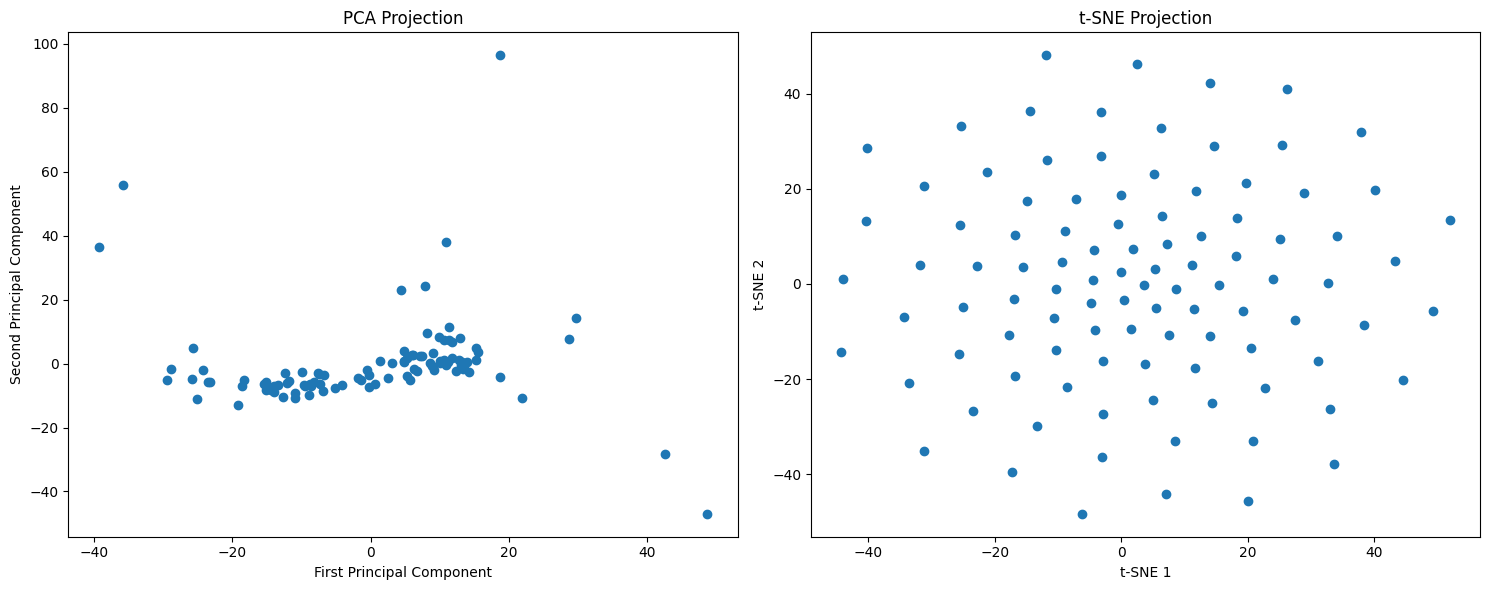

PCA explained variance ratio: [0.0212802  0.01969475]
Total explained variance: 0.0410


In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def analyze_dimensionality(dataset, n_samples=100):
    # Collect weight vectors
    weight_vectors = []
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        weight_vectors.append(weights.numpy())
    
    weight_vectors = np.array(weight_vectors)
    
    # PCA Analysis
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weight_vectors)
    
    # t-SNE Analysis
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(weight_vectors)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.scatter(pca_result[:, 0], pca_result[:, 1])
    ax1.set_title('PCA Projection')
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')
    
    ax2.scatter(tsne_result[:, 0], tsne_result[:, 1])
    ax2.set_title('t-SNE Projection')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

analyze_dimensionality(dataset)

## 6. Summary Statistics

c:\Users\matze\Documents\0_TUM\ADL4CV\HyperDiffusion-main\dataset.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(dir, map_location="cpu")


Dataset Statistics:
Number of samples analyzed: 1000
Total number of weights: 36737000

Weight Statistics:
Mean: -0.1216
Std: 0.7879
Min: -45.2322
Max: 19.9485

Percentiles:
25th: -0.1400
50th: -0.0400
75th: 0.0520


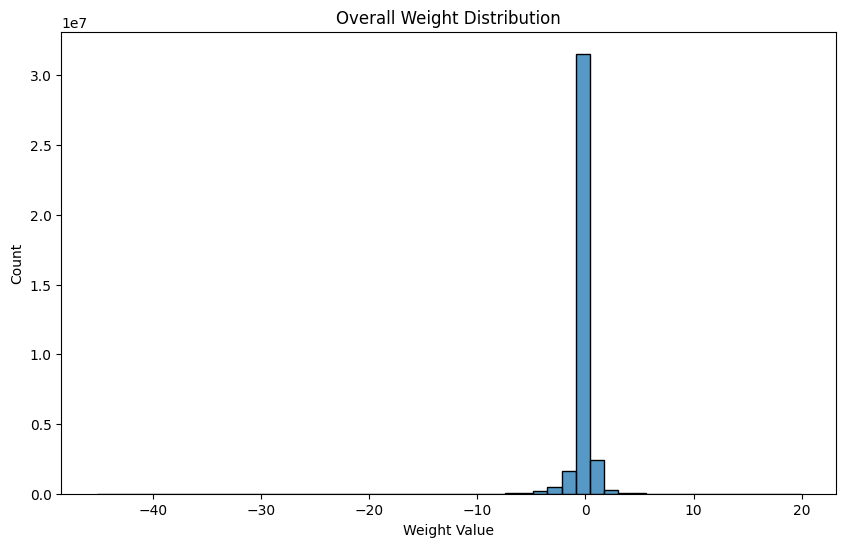

In [14]:
def compute_dataset_statistics(dataset, n_samples=1000):
    all_weights = []
    for i in range(min(n_samples, len(dataset))):
        weights, _, _ = dataset[i]
        all_weights.append(weights.numpy())
    
    all_weights = np.concatenate(all_weights)
    
    print("Dataset Statistics:")
    print(f"Number of samples analyzed: {n_samples}")
    print(f"Total number of weights: {len(all_weights)}")
    print(f"\nWeight Statistics:")
    print(f"Mean: {np.mean(all_weights):.4f}")
    print(f"Std: {np.std(all_weights):.4f}")
    print(f"Min: {np.min(all_weights):.4f}")
    print(f"Max: {np.max(all_weights):.4f}")
    print(f"\nPercentiles:")
    print(f"25th: {np.percentile(all_weights, 25):.4f}")
    print(f"50th: {np.percentile(all_weights, 50):.4f}")
    print(f"75th: {np.percentile(all_weights, 75):.4f}")
    
    # Plot overall distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(all_weights, bins=50)
    plt.title('Overall Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Count')
    plt.show()

compute_dataset_statistics(dataset)